# [Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM)](https://github.com/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec6-RNN.ipynb)

Sample 2, 4, 6, 8

Prediction 1: 10, 12, 14, 16

Prediction 2: 10.1, 12.3, 14.6 <- Error propagates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

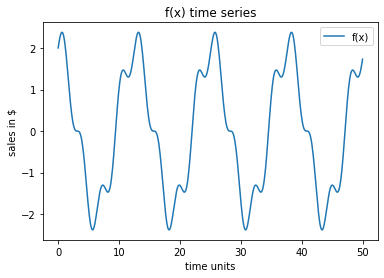

In [3]:
def f(t):
    return .5*np.sin(2*t)+2*np.cos(.5*t)

x = np.linspace(0, 50, 500)
df = pd.DataFrame(f(x), index=x, columns=['f(x)'])

df.plot(title='f(x) time series', xlabel='time units', ylabel='sales in $');

## Train|Test split

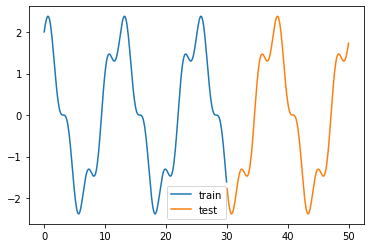

In [42]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(ax=ax)
df_test.plot(ax=ax)
plt.legend(['train','test']);

## Scale data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

scaled_test.shape, scaled_train.shape, scaled_train.max(), scaled_test.min()

((200, 1), (300, 1), 1.0, 0.00011292154516773234)

In [11]:
scaled_train[:10]

array([[0.92060128],
       [0.94100583],
       [0.95951831],
       [0.9753384 ],
       [0.98773411],
       [0.99607139],
       [0.99983981],
       [0.99867346],
       [0.99236611],
       [0.98088013]])

## Time series batches

format: (batch_size, time_steps, dimensionality)

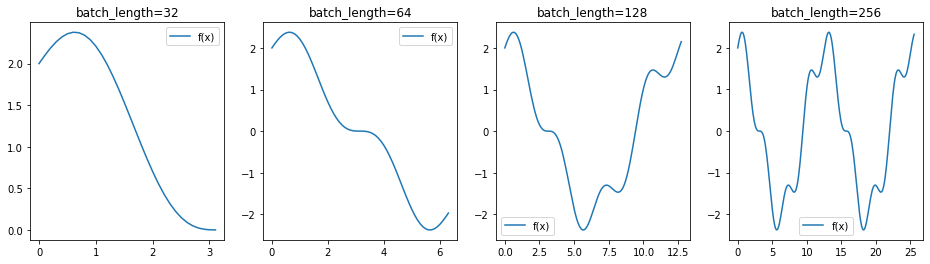

In [15]:
batch_lengths = [32, 64, 128, 256]

_, axes = plt.subplots(1,4,figsize=(16,4))

for batch_length,ax in zip(batch_lengths, axes):
    df_train.iloc[:batch_length].plot(ax=ax)
    ax.set_title(f'{batch_length=}')

In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batch_length, batch_size = 128, 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=batch_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=batch_length, batch_size=batch_size)

train_generator

In [18]:
X, y = train_generator[0]
X.shape, y.shape

((1, 128, 1), (1, 1))

In [20]:
X[0,-3:,0], scaled_train[batch_length-3:batch_length].flatten()

(array([0.91183131, 0.93277341, 0.95216592]),
 array([0.91183131, 0.93277341, 0.95216592]))

In [21]:
y, scaled_train[batch_length]

(array([[0.96918959]]), array([0.96918959]))

## RNN model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def RNN_model(RNN_layers):
    model=Sequential()
    model.add(RNN_layers)
    model.add(Dense(1)) # linear layer
    model.compile(loss='mse', optimizer='adam')
    return model

RNN_layers = SimpleRNN(batch_length, return_sequences=False, input_shape=(None,1))
model=RNN_model(RNN_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
172/172 [==============================] - 18s 93ms/step - loss: 0.0113 - val_loss: 5.3114e-04
Epoch 2/10
172/172 [==============================] - 15s 85ms/step - loss: 1.4449e-04 - val_loss: 1.2108e-04
Epoch 3/10
172/172 [==============================] - 14s 82ms/step - loss: 1.5881e-04 - val_loss: 8.0529e-05
Epoch 4/10
172/172 [==============================] - 14s 83ms/step - loss: 2.8994e-04 - val_loss: 1.4610e-04
Epoch 5/10
172/172 [==============================] - 14s 84ms/step - loss: 1.0044e-04 - val_loss: 7.1870e-06
Epoch 6/10
172/172 [==============================] - 14s 83ms/step - loss: 3.8387e-05 - val_loss: 1.5598e-05
Epoch 7/10
172/172 [==============================] - 14s 82ms/step - loss: 6.0911e-05 - val_loss: 1.7189e-05
Epoch 8/10
172/172 [==============================] - 14s 84ms/step - loss: 3.9618e-04 - val_loss: 0.0011
Epoch 9/10
172/172 [==============================] - 16s 94ms/step - loss: 3.2018e-04 - val_loss: 5.4773e-05
Epoch 10/10
172/17

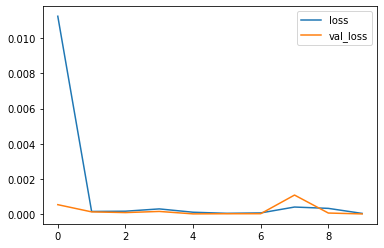

In [27]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

## Predictions

In [37]:
predictions = np.zeros([len(scaled_test),1])
predictions.shape

(200, 1)

In [38]:
first_batch = scaled_train[-batch_length:]
first_batch.shape

(128, 1)

In [39]:
new_batch = first_batch[None, :]
new_batch.shape

(1, 128, 1)

In [40]:
for i,_ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)

y_pred[:3], df_test.iloc[:3].values

(array([[-1.76112142],
        [-1.90526276],
        [-2.03197166]]),
 array([[-1.76620533,  2.46177205],
        [-1.91336611,  2.5586152 ],
        [-2.04466812,  2.61732896]]))

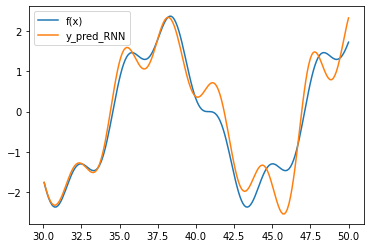

In [43]:
df_test.insert(df_test.shape[1], 'y_pred_RNN', y_pred)
df_test.plot();

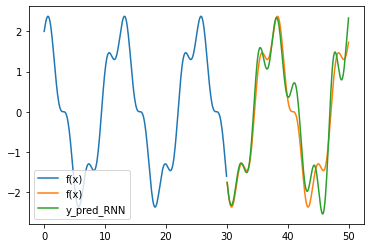

In [45]:
ax = df_train.plot()
df_test.plot(ax=ax);

## Forecasting

- Train on all data
- Predicting into the unknown future

In [46]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(batch_length, return_sequences=False, input_shape=(None,1))
model = RNN_model(LSTM_layer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [47]:
scaler = MinMaxScaler()
all_data_scaled = scaler.fit_transform(df)
all_data_generator = TimeseriesGenerator(all_data_scaled, all_data_scaled, length=batch_length, batch_size=batch_size)

model.fit(all_data_generator, epochs=10)

Epoch 1/10
372/372 [==============================] - 8s 11ms/step - loss: 0.0133
Epoch 2/10
372/372 [==============================] - 4s 11ms/step - loss: 0.0011
Epoch 3/10
372/372 [==============================] - 4s 11ms/step - loss: 5.6435e-04
Epoch 4/10
372/372 [==============================] - 4s 11ms/step - loss: 1.5311e-04
Epoch 5/10
372/372 [==============================] - 4s 11ms/step - loss: 2.9529e-05
Epoch 6/10
372/372 [==============================] - 4s 11ms/step - loss: 1.7463e-05
Epoch 7/10
372/372 [==============================] - 4s 11ms/step - loss: 7.0415e-06
Epoch 8/10
372/372 [==============================] - 4s 11ms/step - loss: 0.0013
Epoch 9/10
372/372 [==============================] - 4s 11ms/step - loss: 2.5421e-04
Epoch 10/10
372/372 [==============================] - 4s 11ms/step - loss: 7.5375e-05


In [62]:
steps_in_future = 50

predictions = np.zeros([steps_in_future,1])
first_batch = all_data_scaled[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)

y_pred[:3]

array([[1.80895411],
       [1.90642701],
       [1.98846178]])

In [63]:
df.tail()

,f(x)
49.599198,1.404160
49.699399,1.467753
49.799599,1.544646
49.899800,1.632719
50.000000,1.729223


In [64]:
X_future = np.linspace(50.1, 50.1 + steps_in_future*.1, num=steps_in_future)
X_future

array([50.1       , 50.20204082, 50.30408163, 50.40612245, 50.50816327,
       50.61020408, 50.7122449 , 50.81428571, 50.91632653, 51.01836735,
       51.12040816, 51.22244898, 51.3244898 , 51.42653061, 51.52857143,
       51.63061224, 51.73265306, 51.83469388, 51.93673469, 52.03877551,
       52.14081633, 52.24285714, 52.34489796, 52.44693878, 52.54897959,
       52.65102041, 52.75306122, 52.85510204, 52.95714286, 53.05918367,
       53.16122449, 53.26326531, 53.36530612, 53.46734694, 53.56938776,
       53.67142857, 53.77346939, 53.8755102 , 53.97755102, 54.07959184,
       54.18163265, 54.28367347, 54.38571429, 54.4877551 , 54.58979592,
       54.69183673, 54.79387755, 54.89591837, 54.99795918, 55.1       ])

In [65]:
df_forecast = pd.DataFrame(y_pred, columns=['forecast'], index=X_future)
df_forecast.head()

,forecast
50.100000,1.808954
50.202041,1.906427
50.304082,1.988462
50.406122,2.055115
50.508163,2.104555


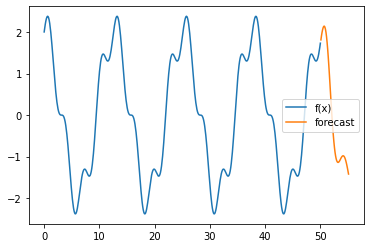

In [66]:
ax = df.plot()
df_forecast.plot(ax=ax);

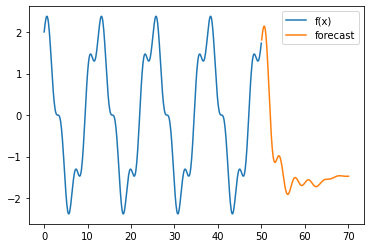

In [68]:
steps_in_future = 200

predictions = np.zeros([steps_in_future,1])
first_batch = all_data_scaled[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)
X_future = np.linspace(50.1, 50.1 + steps_in_future*.1, num=steps_in_future)
df_forecast = pd.DataFrame(y_pred, columns=['forecast'], index=X_future)
ax = df.plot()
df_forecast.plot(ax=ax);

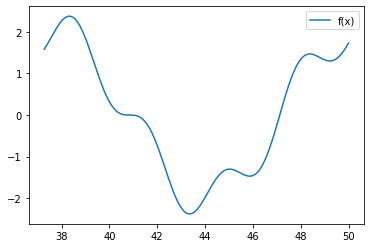

In [69]:
df.iloc[-batch_length:].plot();